# Coursera Applied Data Science Capstone Project


## The Battle of Neighborhood


### Author: Anoop Kohale

#### Introduction/Business Problem

Market analysis is an important part of any business startup. The success or failure depends on the location where the business is opened. In big cities like New York, there is lot of competition to attract customers with your offerings. However, selection a perfect neighbourhood is often difficult and require lot of work.  

Opening any business in any neighborhood requires carefully analyzing number of aspects of the business for it to become successful. There are number of factors influencing the decision, viz. will there be enough customers to buy my offerings, is there any competition around that can take away by revenue, etc. To success the businessman must carefully study these factors and come up with the strategy or plan of operating the business in the neighborhood.  

Fortunately, Advanced data analysis and machine learning will help taking this decision with the information available in abundance around the internet. Foursquare is such an information provider. Foursquare provides data about the interesting venues around any neighborhood. We can utilize the machine learning algorithms and find out the clustering of specific business in the neighborhood. This will empower us with the understanding of demographics and we can then take better decision that will result in making the business a success.  

The main beneficiary of this project will be any entrepreneur who wishes to open a business in big city like New York. The project will try to find a suitable neighbourhood to open a business. For example, someone wants to open a bakery and is looking for a suitable neighbourhood, this project will give an insight on to the venues in a neighbourhood and then can decide whether opening a bakery there will be a suitable option. E.g. if there are other bakeries in the neighbourhood it may not be a suitable option.


#### Data to be used

Any location you open a business has number of other similar businesses operating. One needs to analyse the data available at your hands to come up with a decision. During this project we will gather data from various data sources. Below is the list of the data sources used for this project.  

1.	Foursquare Venues data
    - Type: API Call to Foursquare. JSON data about the venue.
    - Description: The data has various venues around a location within specific radius. Venues are categorized and reviewed by users of Foursquare
    - Source: [Foursquare](https://www.foursquare.com)
2.	Geocoder data
    - Type: Latitude and Longitude data for given location
    - Description: The latitude and longitude data of a given location can be extracted using GEOCODER library
    - Source: Geocoder library
3.	Neighbourhood data
    - Type: Neighbourhoods around New York city
    - Description: Neighbourhoods of New York city
    - Format: GeoJSON data
    - Source: [NYU Neighbourhood Data](https://geo.nyu.edu/catalog/nyu-2451-34572)  
    
The main features of the data will be neighbourhood and their latitude and longitude. Foursquare API will provide data about the venues near by the latitude and longitude of the neighbourhood. This data will include category of the venue, its popularity in terms of user ratings and other related data.
Using this information, we can cluster the venues using clustering techniques. The clusters then will be visualized to take decision. 


Import libraries. All the modules required are already installed on the system

In [18]:
# Pandas to get data in dataframe
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import os
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans


This is a function to get the geo location data using **Geocoder** package

In [2]:
CLIENT_ID = 'JRHV2F5NFMSJ3VRLUQ50LOHIN30Q3S1QX40HZBVFYQ5WICUL' # your Foursquare ID
CLIENT_SECRET = 'YQGRGPOYH2XFYUC0BIY3TF4FDHVUIDMPXBXO1FQ5FVE4VNNJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer", timeout=15)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Now define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return the dataframe with columns as venue id , venue name and category.

In [4]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [57]:
def get_venues(lat,lng):
    
    #set variables
    radius=500
    LIMIT=100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id = row['venue']['id']
            venue_name = row['venue']['name']
            venue_category = row['venue']['categories'][0]['name'] # Get category of Venue
            venue_lat = row['venue']['location']['lat'] 
            venue_lng = row['venue']['location']['lng'] 
            venue_details.append([venue_id,venue_name,venue_category,venue_lat,venue_lng])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category','Lat','Lng']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [6]:
def get_venue_details(venue_id):
  
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now read the data about Ney York Neighborhood. The data is already downloaded and is read from the local file

In [7]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [8]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Looking at the .JSON file, we can see that the borough data is located in **'features'** key.  
Also, **'coordinates'** key gives us the lattitude and longitude of the neighbourhood  
Other fields that are useful to us are **'name'** and **'borough'**  

So, now extract this data from .json file and make a pandas dataframe

In [9]:
neighborhoods_data = newyork_data['features']

In [10]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [11]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [12]:
# inspect the data read
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [13]:
# Find its shape
neighborhoods.shape

(306, 4)

We can see that there are 306 neighborhoods in New York city.

In [14]:
latitude, longitude = geo_location('New York City, NY')
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


#### Create map of New York City and superimpose the neighborhoods on it

In [15]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Now lets find out the different venues around each of the neighborhood of New York.  

In [69]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'N_Lat','N_Lng','ID','Name','Category','Lat','Lng']
venues_ny=pd.DataFrame(columns=column_names)

for row in neighborhoods.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    # return only relevant information for each nearby venue
    for venue in venues.itertuples():
        venues_ny = venues_ny.append({
            'Borough':Borough,
            'Neighborhood': Neighborhood,
            'N_Lat':Latitude,
            'N_Lng':Longitude,
            'ID':venue.ID,#['ID'],
            'Name':venue.Name,#['Name'],
            'Category':venue.Category,#['Category'],
            'Lat':venue.Lat,#['Lat'],
            'Lng':venue.Lng#['Lng']
        }, ignore_index=True)
        
venues_ny.head()

Borough Neighborhood      N_Lat      N_Lng                        ID  \
0   Bronx    Wakefield  40.894705 -73.847201  4c537892fd2ea593cb077a28   
1   Bronx    Wakefield  40.894705 -73.847201  4d6af9426107f04dedeb297a   
2   Bronx    Wakefield  40.894705 -73.847201  4c783cef3badb1f7e4244b54   
3   Bronx    Wakefield  40.894705 -73.847201  4c25c212f1272d7f836385c5   
4   Bronx    Wakefield  40.894705 -73.847201  4d33665fb6093704b80001e0   

               Name        Category        Lat        Lng  
0  Lollipops Gelato    Dessert Shop  40.894123 -73.845892  
1          Rite Aid        Pharmacy  40.896649 -73.844846  
2  Carvel Ice Cream  Ice Cream Shop  40.890487 -73.848568  
3     Dunkin Donuts      Donut Shop  40.890459 -73.849089  
4            SUBWAY  Sandwich Place  40.890656 -73.849192

In [70]:
venues_ny.shape

(10218, 9)

We can see that there are around 10218 venues returned by Foursquare. We will save them to a CSV file to be used later

In [96]:
venues_ny.to_csv('newyork_venues.csv', index=False)

Lets find out Bakeries in all the nwighbourhoods in New York

In [80]:
ny_bakeries = venues_ny[venues_ny.Category.str.contains('Bakery')]
ny_bakeries.shape

(234, 9)

We can see that there are 234 bakeries

In [83]:
ny_bakeries.head()

Borough        Neighborhood      N_Lat      N_Lng  \
45    Bronx         Eastchester  40.887556 -73.827806   
80    Bronx         Kingsbridge  40.881687 -73.902818   
87    Bronx         Kingsbridge  40.881687 -73.902818   
168   Bronx            Woodlawn  40.898273 -73.867315   
317   Bronx  University Heights  40.855727 -73.910416   

                           ID                  Name Category        Lat  \
45   4f44d4d419836ed00196d410         Hostess Cakes   Bakery  40.884688   
80   4debd81822713dd973b85876  Sugarboy Bakery Cafe   Bakery  40.877832   
87   4cab0bf1d971b1f7873327e1      S & S Cheesecake   Bakery  40.884793   
168  4b79c7c2f964a5209b112fe3     Angelica's Bakery   Bakery  40.899183   
317  4e5f8bde45dd4656dd97be19           Au Bon Pain   Bakery  40.858062   

           Lng  
45  -73.826647  
80  -73.902669  
87  -73.899861  
168 -73.867553  
317 -73.912040

Bakeris are plotted on the map of New York

In [139]:
# create map of Bakeries in New York using latitude and longitude values
map_bakeries_ny = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, neighborhood in zip(ny_bakeries['Lat'], ny_bakeries['Lng'], ny_bakeries['Name'], ny_bakeries['Neighborhood']):
    label = '{}, {}'.format(name, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bakeries_ny)  
    
map_bakeries_ny

Lets plot the number of bakeries around the neighbourhoods of New York

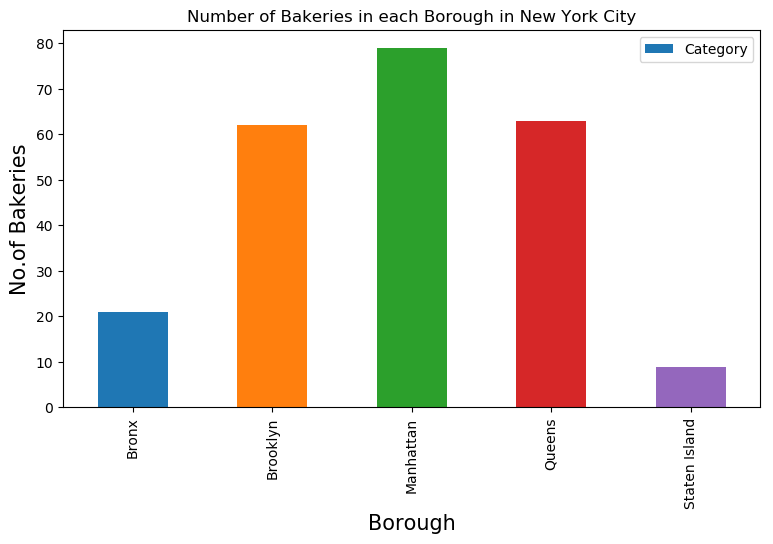

In [92]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Bakeries in each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Bakeries', fontsize=15)
#giving a bar plot
ny_bakeries.groupby('Borough')['Category'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

With the above bar chart, we can see that Manhattan, Borrklyn and Queens have large number of bakeries.  
This provides an opportunity to open up bakeries in Bronx and Staten Island.  
However, we will perform more analysis of neighbourhoods and get try to narrow down the places

First, lets find out how many bakeries are there in each neighbourhood

In [95]:
ny_bakeries.groupby('Neighborhood').count()

Borough  N_Lat  N_Lng  ID  Name  Category  Lat  Lng
Neighborhood                                                                  
Astoria                          5      5      5   5     5         5    5    5
Astoria Heights                  1      1      1   1     1         1    1    1
Bath Beach                       1      1      1   1     1         1    1    1
Battery Park City                1      1      1   1     1         1    1    1
Bay Terrace                      1      1      1   1     1         1    1    1
Bayside                          2      2      2   2     2         2    2    2
Belle Harbor                     1      1      1   1     1         1    1    1
Belmont                          5      5      5   5     5         5    5    5
Bensonhurst                      1      1      1   1     1         1    1    1
Boerum Hill                      2      2      2   2     2         2    2    2
Brighton Beach                   1      1      1   1     1         1    1    1
Brooklyn Heights                 2      2      2   2     2         2    2    2
Bushwick                         3      3      3   3     3         3    3    3
Cambria Heights                  1      1      1   1     1         1    1    1
Carnegie Hill                    2      2      2   2     2         2    2    2
Carroll Gardens                  4      4      4   4     4         4    4    4
Central Harlem                   1      1      1   1     1         1    1    1
Charleston                       1      1      1   1     1         1    1    1
Chelsea                          4      4      4   4     4         4    4    4
Chinatown                        3      3      3   3     3         3    3    3
Civic Center                     5      5      5   5     5         5    5    5
Claremont Village                1      1      1   1     1         1    1    1
Clifton                          1      1      1   1     1         1    1    1
Clinton                          1      1      1   1     1         1    1    1
Clinton Hill                     1      1      1   1     1         1    1    1
Cobble Hill                      2      2      2   2     2         2    2    2
College Point                    2      2      2   2     2         2    2    2
Concourse                        1      1      1   1     1         1    1    1
Corona                           2      2      2   2     2         2    2    2
Crown Heights                    1      1      1   1     1         1    1    1
Douglaston                       1      1      1   1     1         1    1    1
Downtown                         2      2      2   2     2         2    2    2
Dumbo                            3      3      3   3     3         3    3    3
East Elmhurst                    1      1      1   1     1         1    1    1
East Flatbush                    1      1      1   1     1         1    1    1
East Harlem                      4      4      4   4     4         4    4    4
East Village                     1      1      1   1     1         1    1    1
East Williamsburg                3      3      3   3     3         3    3    3
Eastchester                      1      1      1   1     1         1    1    1
Eltingville                      1      1      1   1     1         1    1    1
Financial District               1      1      1   1     1         1    1    1
Flatiron                         3      3      3   3     3         3    3    3
Flushing                         3      3      3   3     3         3    3    3
Fordham                          1      1      1   1     1         1    1    1
Forest Hills                     1      1      1   1     1         1    1    1
Forest Hills Gardens             3      3      3   3     3         3    3    3
Fort Hamilton                    1      1      1   1     1         1    1    1
Fulton Ferry                     2      2      2   2     2         2    2    2
Glen Oaks                        1      1      1   1     1         1    1    

Now get the ratings of the bakeries selected above. Ratings will include user ratings, likes and total tips provided by users.  
We will cluster the bakeries based on these variables to get an insight on the consumer sentiments of these shops.

In [98]:
# prepare neighborhood list of Bakeries with likes, tarings and tips
column_names=['Borough', 'Neighborhood', 'Lat', 'Lng', 'ID','Name','Likes','Rating','Tips']
bakeries_stats_ny=pd.DataFrame(columns=column_names)

for row in ny_bakeries.values.tolist():
    Borough,Neighborhood,N_Lat, N_Lng, ID, Name, Category, Lat, Lng = row
    try:
        venue_dtl = get_venue_details(ID)
        id,name,likes,rating,tips=venue_dtl.values.tolist()[0]
    except IndexError:
        # If there are no details available, we will give all 0
        id,name,likes,rating,tips=[0]*5
        
    # Collect results in a dataframe
    bakeries_stats_ny = bakeries_stats_ny.append(
                                                {
                                                    'Borough':Borough,
                                                    'Neighborhood':Neighborhood,
                                                    'Lat':Lat,
                                                    'Lng':Lng,
                                                    'ID':ID,
                                                    'Name':Name,
                                                    'Likes':likes,
                                                    'Rating':rating,
                                                    'Tips':tips
                                                }, ignore_index=True
                                                )
    
bakeries_stats_ny.head()

Borough        Neighborhood        Lat        Lng                        ID  \
0   Bronx         Eastchester  40.884688 -73.826647  4f44d4d419836ed00196d410   
1   Bronx         Kingsbridge  40.877832 -73.902669  4debd81822713dd973b85876   
2   Bronx         Kingsbridge  40.884793 -73.899861  4cab0bf1d971b1f7873327e1   
3   Bronx            Woodlawn  40.899183 -73.867553  4b79c7c2f964a5209b112fe3   
4   Bronx  University Heights  40.858062 -73.912040  4e5f8bde45dd4656dd97be19   

                   Name Likes Rating Tips  
0         Hostess Cakes     0      0    0  
1  Sugarboy Bakery Cafe    15    7.8    0  
2      S & S Cheesecake    12    7.5    2  
3     Angelica's Bakery     0      0    0  
4           Au Bon Pain     2    6.3    1

In [99]:
#Save these results to CSV for later use since the calls to get ratings is premium and only 500 are allowed in a day
bakeries_stats_ny.to_csv('bakeries_stat_ny.csv', index=False)

In [100]:
# Find out shape and characteristics of the data
bakeries_stats_ny.shape

(234, 9)

In [107]:
# Convert Ratings, tips and likes to integer
bakeries_stats_ny['Likes'] = bakeries_stats_ny['Likes'].astype('int64')
bakeries_stats_ny['Rating'] = bakeries_stats_ny['Rating'].astype('int64')
bakeries_stats_ny['Tips'] = bakeries_stats_ny['Tips'].astype('int64')

In [108]:
bakeries_stats_ny.dtypes

Borough          object
Neighborhood     object
Lat             float64
Lng             float64
ID               object
Name             object
Likes             int64
Rating            int64
Tips              int64
dtype: object

In [109]:
bakeries_stats_ny.describe()

Lat         Lng        Likes      Rating        Tips
count  234.000000  234.000000   234.000000  234.000000  234.000000
mean    40.731587  -73.939832   129.991453    6.675214   49.145299
std      0.069085    0.079379   274.975972    2.699003  106.351532
min     40.523312  -74.230862     0.000000    0.000000    0.000000
25%     40.700809  -73.990785     7.000000    7.000000    3.000000
50%     40.732057  -73.956416    26.000000    8.000000   11.500000
75%     40.767038  -73.895285   132.750000    8.000000   44.000000
max     40.899183  -73.715476  2372.000000    9.000000  932.000000

Now lets plot the likes, ratings and Tips as box plot to visualize their distribution

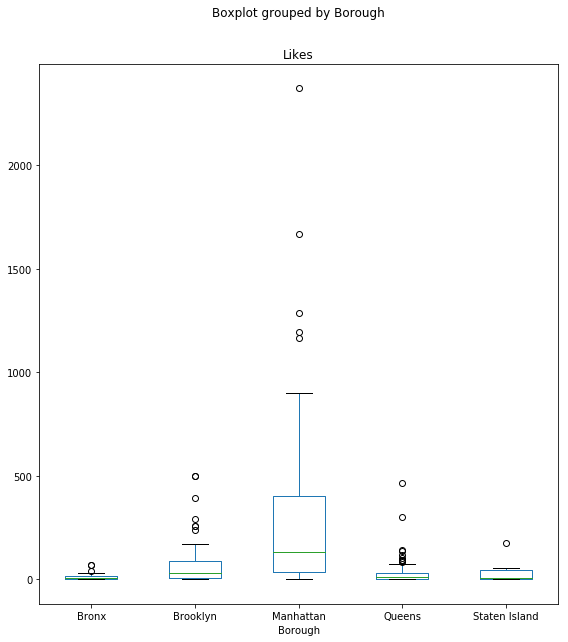

In [149]:
bakeries_stats_ny.boxplot(by='Borough', column=['Likes'], grid=False, figsize=[9,10])


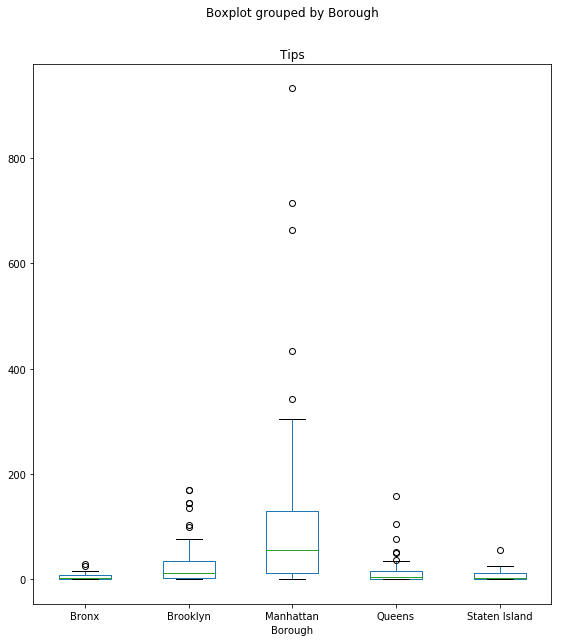

In [151]:
bakeries_stats_ny.boxplot(by='Borough', column=['Tips'], grid=False, figsize=[9,10])


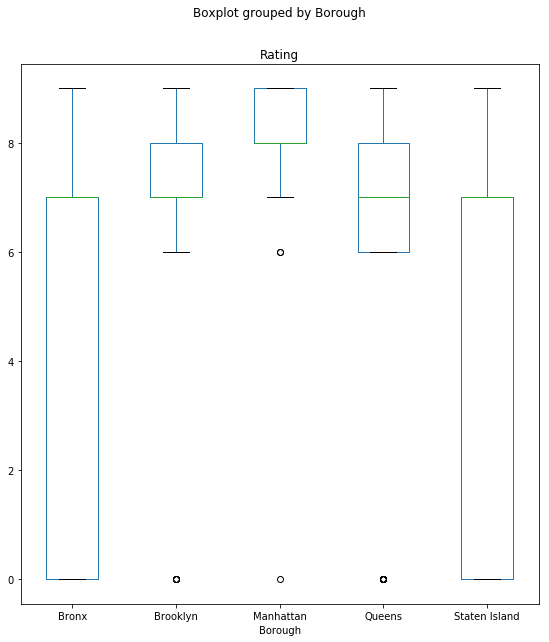

In [152]:
bakeries_stats_ny.boxplot(by='Borough', column=['Rating'], grid=False, figsize=[9,10])


Now visualize the Likes, Ratings and tips for each venue.  
We will plot the bar chart fo these values. To make dataset smaller, we will drop the rows where there is no ratings data

In [117]:
bakeries_stats_ny_non0 = bakeries_stats_ny[(bakeries_stats_ny.Likes > 0) & (bakeries_stats_ny.Rating > 0) & (bakeries_stats_ny.Tips > 0)].reset_index(drop=True)

In [118]:
bakeries_stats_ny_non0.head()

Borough        Neighborhood        Lat        Lng                        ID  \
0   Bronx         Kingsbridge  40.884793 -73.899861  4cab0bf1d971b1f7873327e1   
1   Bronx  University Heights  40.858062 -73.912040  4e5f8bde45dd4656dd97be19   
2   Bronx          Morrisania  40.822081 -73.900749  4bc3300674a9a5931826d4f6   
3   Bronx         Morris Park  40.849241 -73.853613  4bbf3ae8f353d13a5f397e10   
4   Bronx         Morris Park  40.848311 -73.855898  4c348cea213c2d7ff79e385d   

                      Name  Likes  Rating  Tips  
0         S & S Cheesecake     12       7     2  
1              Au Bon Pain      2       6     1  
2              Amor Bakery      7       7     2  
3  Joseph Scaglione Bakery     11       7     6  
4    Morris Park Bake Shop      6       6     3

In [119]:
bakeries_stats_ny_non0.shape

(197, 9)

Now lets cluster bakeries based on their ratings ,likes and tips received into 5 clusters

In [123]:
bakeries_clustering = bakeries_stats_ny_non0.loc[:,['Likes','Rating','Tips']]

In [124]:
bakeries_clustering.head()

Likes  Rating  Tips
0     12       7     2
1      2       6     1
2      7       7     2
3     11       7     6
4      6       6     3

In [125]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bakeries_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [126]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 4, 2, 4, 2, 2, 2, 2, 0, 4,
       1, 2, 4, 4, 2, 0, 0, 2, 0, 0, 3, 0, 1, 3, 2, 2, 0, 0, 4, 0, 0, 2,
       2, 4, 0, 1, 0, 4, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 4, 0, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 4, 2, 0,
       4, 0, 2, 2, 2, 4, 0, 2, 2, 4, 1, 1, 2, 0, 4, 0, 0, 0, 4, 2, 2])

In [127]:
bakeries_stats_ny_non0.insert(0,'ClusterLabels', kmeans.labels_)

bakeries_stats_ny_non0.head()

ClusterLabels Borough        Neighborhood        Lat        Lng  \
0              2   Bronx         Kingsbridge  40.884793 -73.899861   
1              2   Bronx  University Heights  40.858062 -73.912040   
2              2   Bronx          Morrisania  40.822081 -73.900749   
3              2   Bronx         Morris Park  40.849241 -73.853613   
4              2   Bronx         Morris Park  40.848311 -73.855898   

                         ID                     Name  Likes  Rating  Tips  
0  4cab0bf1d971b1f7873327e1         S & S Cheesecake     12       7     2  
1  4e5f8bde45dd4656dd97be19              Au Bon Pain      2       6     1  
2  4bc3300674a9a5931826d4f6              Amor Bakery      7       7     2  
3  4bbf3ae8f353d13a5f397e10  Joseph Scaglione Bakery     11       7     6  
4  4c348cea213c2d7ff79e385d    Morris Park Bake Shop      6       6     3

Finally lets visualize the results on a map

In [128]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bakeries_stats_ny_non0['Lat'], bakeries_stats_ny_non0['Lng'], bakeries_stats_ny_non0['Neighborhood'], bakeries_stats_ny_non0['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Lets Examine the clusters

### Cluster 1

In [131]:
bakeries_stats_ny_non0.loc[bakeries_stats_ny_non0['ClusterLabels'] == 0, bakeries_stats_ny_non0.columns[[1,2] + list(range(5, bakeries_stats_ny_non0.shape[1]))]]

Borough       Neighborhood                        ID  \
24        Brooklyn   Prospect Heights  548eeada498e4c3cf0acd057   
26        Brooklyn   Prospect Heights  44f9a2c4f964a52066381fe3   
30        Brooklyn   Brooklyn Heights  4f86cb13e4b05dd564791c7d   
38        Brooklyn           Red Hook  44dc6750f964a520a6361fe3   
39        Brooklyn         Park Slope  4b7d51f3f964a52013b82fe3   
56        Brooklyn         North Side  57f2b5a5498eb5093e5fb8bb   
57        Brooklyn         North Side  5241e37c498e5ed64d425a21   
58        Brooklyn         North Side  4197f180f964a520151e1fe3   
60       Manhattan          Chinatown  482c4142f964a520d14f1fe3   
61       Manhattan          Chinatown  49d55b3bf964a5208d5c1fe3   
62       Manhattan          Chinatown  3fd66200f964a520bce61ee3   
86       Manhattan     Lincoln Square  56ba9f99498ef6f5b55a33dc   
93       Manhattan            Chelsea  4a284b61f964a52007951fe3   
94       Manhattan            Chelsea  4a33b48ff964a520379b1fe3   
96       Manhattan            Chelsea  4cd1d42cde0f6dcb316e7363   
97       Manhattan  Greenwich Village  4b4c863cf964a52026b526e3   
99       Manhattan  Greenwich Village  4dd00c6d88778512441f5018   
104      Manhattan            Tribeca  4a01e214f964a52005711fe3   
105      Manhattan       Little Italy  3fd66200f964a520bce61ee3   
107      Manhattan       Little Italy  482c4142f964a520d14f1fe3   
108      Manhattan       Little Italy  49eb223ff964a520a6661fe3   
112      Manhattan               Soho  53ab0af5498e13bffddb8d96   
114      Manhattan       West Village  512e5398e4b01d7d36f95f00   
116      Manhattan   Manhattan Valley  42659b80f964a52033211fe3   
134         Queens           Flushing  4bb92b2598c7ef3b95e03102   
147         Queens            Bayside  4a972133f964a520982820e3   
152         Queens        Bay Terrace  4ac3a1a9f964a5201f9c20e3   
156         Queens        Lefrak City  4dbf345afa8cc78a860cbc44   
165  Staten Island           Old Town  4b6c648bf964a5205d362ce3   
167      Manhattan      Carnegie Hill  53e4c5b2498ea330eb3c8083   
171      Manhattan       Civic Center  537b5258498e262a54b47216   
175      Manhattan       Civic Center  54346275498e3d6955212743   
177      Manhattan      Midtown South  4c892b0f7223b1f7dfb031a8   
182      Manhattan       Sutton Place  528c0a8411d22d20135e7756   
189       Brooklyn       Fulton Ferry  43504680f964a520b0281fe3   
191       Brooklyn       Vinegar Hill  52b204c0498efe3c3be32d91   
192       Brooklyn              Dumbo  52b204c0498efe3c3be32d91   
193       Brooklyn              Dumbo  43504680f964a520b0281fe3   

                                   Name  Likes  Rating  Tips  
24              Little Cupcake Bakeshop    143       8    27  
26                       Joyce Bakeshop    135       8    76  
30                    Le Pain Quotidien    143       7    39  
38                                Baked    291       9   135  
39        Cousin John's Cafe and Bakery    141       8    55  
56              Martha's Country Bakery    236       8    44  
57                   Caprices by Sophie    136       9    55  
58         Fabiane's Cafe & Pastry Shop    168       7   103  
60                        Fay Da Bakery    132       8    56  
61                           Mei Li Wah    241       8   141  
62                     La Bella Ferrara    161       9    91  
86       Breads Bakery - Lincoln Center    159       9    38  
93                     Fat Witch Bakery    144       8    67  
94                          Amy's Bread    198       8   107  
96                          Empire Cake    232       9   122  
97   Birdbath Neighborhood Green Bakery    264       8   149  
99                 Mille-Feuille Bakery    168       8    95  
104                    Grandaisy Bakery    170       8    94  
105                    La Bella Ferrara    161       9    91  
107                       Fay Da Bakery    132       8    56  
108                   Tai Pan Bakery 大班    215       8    83  
112        

This Cluster is the **3rd heightest** rated and liked baleries with most tips.   
These are mainly situated in **Manhattan, Brooklyn and Queens** Borough.

### Cluster 2

In [132]:
bakeries_stats_ny_non0.loc[bakeries_stats_ny_non0['ClusterLabels'] == 1, bakeries_stats_ny_non0.columns[[1,2] + list(range(5, bakeries_stats_ny_non0.shape[1]))]]

Borough  Neighborhood                        ID  \
88   Manhattan       Clinton  4fab5090e4b0eeffb5c77119   
100  Manhattan  East Village  3fd66200f964a5208be41ee3   
113  Manhattan  West Village  3fd66200f964a5203be71ee3   
186  Manhattan      Flatiron  4079dc00f964a52070f21ee3   
187  Manhattan      Flatiron  503fb6d4ebca66a84f029bd8   

                              Name  Likes  Rating  Tips  
88                    Schmackary's    902       9   276  
100  Veniero’s Pasticceria & Caffe    897       9   301  
113                Magnolia Bakery   1167       8   433  
186                The City Bakery   1288       8   663  
187                  Breads Bakery   1195       9   305

This cluster is the **2nd Heightest** rated and liked Bakeries in New York city.  
We can see that they are located mainly in Manhattan Borough.

### Cluster 3

In [134]:
bakeries_stats_ny_non0.loc[bakeries_stats_ny_non0['ClusterLabels'] == 2, bakeries_stats_ny_non0.columns[[1,2] + list(range(5, bakeries_stats_ny_non0.shape[1]))]]

Borough               Neighborhood                        ID  \
0            Bronx                Kingsbridge  4cab0bf1d971b1f7873327e1   
1            Bronx         University Heights  4e5f8bde45dd4656dd97be19   
2            Bronx                 Morrisania  4bc3300674a9a5931826d4f6   
3            Bronx                Morris Park  4bbf3ae8f353d13a5f397e10   
4            Bronx                Morris Park  4c348cea213c2d7ff79e385d   
5            Bronx                    Belmont  4bb6496e46d4a59398fdc5c0   
6            Bronx                    Belmont  4af1a473f964a520c5e121e3   
7            Bronx                    Belmont  4b366de6f964a5202d3525e3   
8            Bronx                    Belmont  4ab52b10f964a520f37220e3   
9            Bronx                    Belmont  4c823993d8086dcbc8207452   
10           Bronx                 Pelham Bay  4c9205941adc370460a134d1   
11           Bronx                  Concourse  4c9bb31e9975a1438f922bcf   
12        Brooklyn                Bensonhurst  4b972c7cf964a52008fb34e3   
13        Brooklyn                Sunset Park  4ad24975f964a520b4e020e3   
14        Brooklyn                Sunset Park  4bb15325f964a520608c3ce3   
15        Brooklyn                 Greenpoint  4be6fef12468c928b2ef0143   
16        Brooklyn                 Greenpoint  59c68c0c4382ab16da7cf734   
18        Brooklyn                  Gravesend  4da602dacda1b0253fe9192e   
19        Brooklyn                  Gravesend  4c75a5ed3adda143830208af   
20        Brooklyn             Brighton Beach  51799baae4b0e3bd46874775   
21        Brooklyn              Crown Heights  4b50addbf964a520132d27e3   
22        Brooklyn                 Kensington  4d6002cb5c39b1f79fc8fe49   
23        Brooklyn            Windsor Terrace  4ac787f5f964a520c9b720e3   
25        Brooklyn           Prospect Heights  4a9e748df964a5203a3a20e3   
27        Brooklyn                   Bushwick  4af0b371f964a5205cde21e3   
28        Brooklyn                   Bushwick  5702a4d1498ec2255b795cfe   
29        Brooklyn                   Bushwick  54bac253498e94c7a5201b01   
31        Brooklyn           Brooklyn Heights  56a122d6498eb97a32f045d4   
32        Brooklyn                Cobble Hill  4a8814faf964a520210520e3   
33        Brooklyn                Cobble Hill  5bd8a65cbfc6d0002c47b7c5   
34        Brooklyn            Carroll Gardens  4a69cfeaf964a52015cc1fe3   
35        Brooklyn            Carroll Gardens  3fd66200f964a52075eb1ee3   
36        Brooklyn            Carroll Gardens  4a75f1d7f964a520c1e11fe3   
37        Brooklyn            Carroll Gardens  4a0db3fdf964a52090751fe3   
40        Brooklyn                 Park Slope  54fb8727498e954a056089b3   
41        Brooklyn                 Bath Beach  4f09f19ae4b0596c9037594a   
42        Brooklyn               Clinton Hill  4aeb55fcf964a5201ac121e3   
43        Brooklyn                   Downtown  595183c718d43b1841112628   
44        Brooklyn                   Downtown  4a14b462f964a5206a781fe3   
45        Brooklyn                Boerum Hill  4a14b462f964a5206a781fe3   
46        Brooklyn                Boerum Hill  5a7660bd646e381165cede73   
47        Brooklyn  Prospect Lefferts Gardens  551713b2498e2dd5c04ca7eb   
48        Brooklyn  Prospect Lefferts Gardens  4b47bad2f964a5203d3c26e3   
49        Brooklyn  Prospect Lefferts Gardens  5532bd18498e3b259fe602c3   
50        Brooklyn  Prospect Lefferts Gardens  53fa2073498e47b1dc5aeb67   
51        Brooklyn                 Ocean Hill  4dc20c4cb0fb490416a7af8e   
52        Brooklyn                    Midwood  4ba695aef964a520706039e3   
53        Brooklyn          East Williamsburg  4a5f65cef964a52081bf1fe3   
54        Brooklyn          East Williamsburg  56b89eb438fa514c68e8a175   
55        Brooklyn          East Williamsburg  566c89bb498efb2d852c92f1   
59        Brooklyn              Fort Hamilton  541af677498eaa82cbfe98e2   
63       Manhattan         Washington Heights  4a5b2d43f964a520eaba1fe3   
64       Manhattan         Washingto

This cluster has the lowest ranked bakeries

### Cluster 4

In [135]:
bakeries_stats_ny_non0.loc[bakeries_stats_ny_non0['ClusterLabels'] == 3, bakeries_stats_ny_non0.columns[[1,2] + list(range(5, bakeries_stats_ny_non0.shape[1]))]]

Borough       Neighborhood                        ID  \
98   Manhattan  Greenwich Village  4eb13d68e5e8c0f5bd2fd983   
101  Manhattan    Lower East Side  40a55d80f964a52020f31ee3   

                                    Name  Likes  Rating  Tips  
98                Dominique Ansel Bakery   2372       9   714  
101  Clinton St. Baking Co. & Restaurant   1668       9   932

This cluster has the highest liked and rated bakeries. These are located in Manhattan.

### Cluster 5

In [136]:
bakeries_stats_ny_non0.loc[bakeries_stats_ny_non0['ClusterLabels'] == 4, bakeries_stats_ny_non0.columns[[1,2] + list(range(5, bakeries_stats_ny_non0.shape[1]))]]

Borough     Neighborhood                        ID  \
17    Brooklyn       Greenpoint  4c4bbf66c668e21ec3a57afa   
75   Manhattan  Upper East Side  4ae37940f964a520869521e3   
78   Manhattan  Upper East Side  4fc95a1ee4b0f9aeca457705   
79   Manhattan        Yorkville  4a06f82df964a52010731fe3   
81   Manhattan       Lenox Hill  4fc95a1ee4b0f9aeca457705   
87   Manhattan   Lincoln Square  4a271f0bf964a5205b911fe3   
90   Manhattan          Midtown  527e819a11d281648dd93142   
91   Manhattan          Midtown  51deeb27498e0bcc94b6538c   
106  Manhattan     Little Italy  49ee25b6f964a5202b681fe3   
111  Manhattan             Soho  49ee25b6f964a5202b681fe3   
115  Manhattan     West Village  551dc635498e1c00cdfd2a53   
151     Queens         Steinway  49c68da1f964a5205b571fe3   
173  Manhattan     Civic Center  4c154c9a77cea593c401d260   
176  Manhattan    Midtown South  4fe4c53fe4b065cd6ec6b9e9   
181  Manhattan     Sutton Place  4e7393931495dffb8efa57da   
185  Manhattan         Flatiron  51e729c2498eb3383944116b   
190   Brooklyn     Fulton Ferry  4f21bb85e5e872143c0ca04b   
194   Brooklyn            Dumbo  4f21bb85e5e872143c0ca04b   

                            Name  Likes  Rating  Tips  
17                        Ovenly    394       9   100  
75          Lady M Cake Boutique    393       9   125  
78                 Maison Kayser    476       9   153  
79           Two Little Red Hens    767       9   342  
81                 Maison Kayser    476       9   153  
87               Magnolia Bakery    667       9   273  
90                 Maison Kayser    456       9    84  
91          Lady M Cake Boutique    416       8   103  
106  Eileen's Special Cheesecake    634       9   234  
111  Eileen's Special Cheesecake    634       9   234  
115      Dominique Ansel Kitchen    512       9   130  
151      Martha's Country Bakery    463       9   159  
173             Takahachi Bakery    647       9   197  
176               Tous Les Jours    518       8   157  
181              Magnolia Bakery    419       9   131  
185                Maison Kayser    750       8   182  
190             One Girl Cookies    501       8   169  
194             One Girl Cookies    501       8   169

## Conclusion

With above study we can conclude that to open up a bakery, Manhattan is the best place in terms of number of customers.  
However, there are  some of the best rated and liked Bakeries are present in Manhattan, giving increased competition to the business.  
Neighborhoods in other Boroughs offer dispersed locations of bakeries. New business can be opened in those locations 